# Sea Routes

This notebook cleans and processes maritime routes from [Mariquant (2019)](https://towardsdatascience.com/creating-sea-routes-from-the-sea-of-ais-data-30bc68d8530e) made available in the following S3 links:

- http://worldroutes.s3.amazonaws.com/routes.csv  
- http://worldroutes.s3.amazonaws.com/distances.csv  
- http://worldroutes.s3.amazonaws.com/ports.csv  

In [1]:
import pandas as pd
import geopandas as gpd
from os.path import join, expanduser
from shapely.geometry import Point
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString
from tqdm import tqdm

pd.set_option("display.max_columns", None)

In [3]:
import sys

gn_path = join(expanduser("~"), "Repos", "GOSTnets")
sys.path.append(gn_path)

In [4]:
import GOSTnets as gn
import osmnx as ox
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%load_ext autoreload
%autoreload 2

## Load Datasets

In [6]:
routes_dir = join(expanduser("~"), "tmp", "sea_routes")
ports = pd.read_csv(join(routes_dir, "ports.csv"), index_col=0)
distances = pd.read_csv(join(routes_dir, "distances.csv"), index_col=0)
routes = pd.read_csv(join(routes_dir, "routes.csv"), index_col=0)

In [7]:
routes.loc[:, "geometry"] = routes.apply(lambda x: Point(x["lon"], x["lat"]), axis=1)
routes = gpd.GeoDataFrame(routes, geometry="geometry", crs="EPSG:4326")

In [10]:
routes.head(3)

,trip_count,prev_port,next_port,lat,lon,frequency,geometry
7641,1984063,4410,3658,45.764835,-87.053288,1.0,POINT (-87.05329 45.76483)
7642,1984063,4410,3658,45.608533,-87.038217,1.0,POINT (-87.03822 45.60853)
7643,1984063,4410,3658,45.560133,-87.034233,1.0,POINT (-87.03423 45.56013)


In [11]:
ports.loc[:, "geometry"] = ports.apply(lambda x: Point(eval(x.coords)[0]), axis=1)
ports = gpd.GeoDataFrame(ports, geometry="geometry", crs="EPSG:4326")

In [12]:
ports.head(2)

,PORT_NAME,INDEX_NO,coords,geometry
49159,Terminal Pesquero Cta. Quiane,NaN,"((-70.31722387298942, -18.513597026467323),)",POINT (-70.31722 -18.51360)
49164,Oil Berth,NaN,"((-61.86886473007713, 17.150384410999997),)",POINT (-61.86886 17.15038)


## Merge Routes with Geometry

### Clean Geometries

Split geometry if it passes the international dateline (180 longitude)

In [13]:
pdc = "EPSG:3832"
wgs = "EPSG:4326"
azimuthal = "ESRI:54032"
rob = "ESRI:54030"

In [14]:
# check if signs of two numbers are different
def sign_diff(a, b):
    return a * b < 0


# split coords by dateline crossing
def split_coords(coords):
    # coords = list(coords)
    xs = [coord.x for coord in coords]
    xs_ = np.sign(xs)

    groups = []
    g = 0
    for i, x in enumerate(xs_):
        groups.append(g)
        if i + 1 == len(xs_):
            break
        else:
            if x != xs_[i + 1]:
                g += 1

    components = []
    for group in np.unique(groups):
        g_mask = [g == group for g in groups]
        comp = coords[g_mask]
        if len(comp) > 1:
            components.append(comp)

    return components


def get_line(row):
    route = routes.loc[routes["trip_count"] == row.trip_count].copy()
    coords = route.geometry.values
    xs = [coord.x for coord in coords]
    # check if route crosses dateline
    n_components = 1
    if sign_diff(np.min(xs), np.max(xs)) and (
        (np.abs(np.min(xs)) + np.abs(np.max(xs))) > 180
    ):
        components = split_coords(coords)
        if len(components) == 1:
            geom = LineString(components[0])
        elif len(components) > 1:
            n_components = len(components)
            geom = MultiLineString(components)
        else:
            geom = None
            n_components = 0
    else:
        geom = LineString(coords)
    return (geom, n_components)

In [15]:
distances = distances.loc[(distances.prev_port != distances.next_port)].copy()

In [16]:
len(distances)

54464

In [295]:
for idx, row in tqdm(distances.iterrows()):
    geom, n_components = get_line(row)
    distances.loc[idx, "geometry"] = geom
    distances.loc[idx, "n_components"] = n_components

54464it [14:08, 64.16it/s]


In [304]:
distances.to_csv(join(routes_dir, "distances_processed.csv"), index=False)

In [17]:
distances = pd.read_csv(join(routes_dir, "distances_processed.csv"))

In [18]:
distances_filt = distances.loc[~(distances.geometry.isna())].copy()

In [19]:
distances_filt.loc[:, "geometry"] = distances_filt.apply(
    lambda x: loads(x.geometry), axis=1
)

In [20]:
ports.reset_index(inplace=True)

In [21]:
distances_filt.n_components.value_counts()

n_components
1.0    52753
2.0     1705
4.0        2
3.0        2
Name: count, dtype: int64

In [22]:
distances = distances_filt.copy()

## Clean Rotues

Remove routes with too many segments

In [23]:
distances = distances.loc[distances.n_components < 3].copy()

In [24]:
distances = gpd.GeoDataFrame(distances, geometry="geometry", crs=wgs)

Remove long routes that intersect land (likely errors) 

In [25]:
land = gpd.read_file(join(expanduser("~"), "tmp", "ne", "ne_50m_land.shp"))

In [26]:
land_geom = land.unary_union

In [27]:
def get_intersect_pct(geom):
    if geom.intersects(land_geom):
        length = geom.length
        length_land = geom.intersection(land_geom).length
        return length_land / length
    else:
        return 0

In [28]:
distances.loc[:, "land_intersect"] = distances.apply(
    lambda x: get_intersect_pct(x.geometry), axis=1
)

In [29]:
distances.land_intersect.describe()

count    54458.000000
mean         0.061974
std          0.197872
min          0.000000
25%          0.000000
50%          0.000110
75%          0.008023
max          1.000000
Name: land_intersect, dtype: float64

In [30]:
len(distances.loc[distances.land_intersect > 0.5])

2597

In [31]:
intersect_thresh = 0.1
length_thresh = distances.length.median()  # 10 #
distances2 = distances.loc[
    ~(
        (distances.land_intersect > intersect_thresh)
        & (distances.length > length_thresh)
    )
].copy()

/tmp/ipykernel_1713433/2524201493.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  length_thresh = distances.length.median()  # 10 #
/tmp/ipykernel_1713433/2524201493.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  & (distances.length > length_thresh)


In [247]:
len(distances2)

53293

## Plot Routes

(-208.73408508695817, 200.2372267536647, -62.9315025035, 83.9357858335)

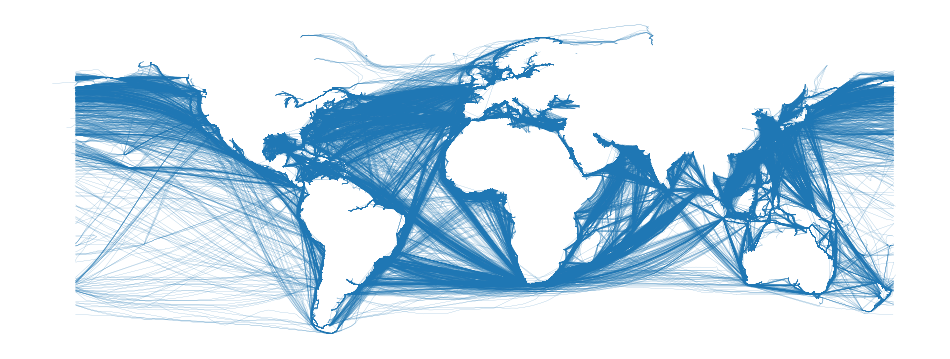

In [248]:
fig, ax = plt.subplots(figsize=(12, 14))
distances2.plot(ax=ax, linewidth=0.1)
plt.axis("off")

In [249]:
ports.head()

,index,PORT_NAME,INDEX_NO,coords,geometry
0,49159,Terminal Pesquero Cta. Quiane,NaN,"((-70.31722387298942, -18.513597026467323),)",POINT (-70.31722 -18.51360)
1,49164,Oil Berth,NaN,"((-61.86886473007713, 17.150384410999997),)",POINT (-61.86886 17.15038)
2,16,Port of Basamuk,NaN,"((146.14295817405977, -5.53913255687803),)",POINT (146.14296 -5.53913)
3,26,Victoria,NaN,"((-123.32715191091728, 48.402783083729446),)",POINT (-123.32715 48.40278)
4,34,NaN,NaN,"((126.50786074843957, 36.333661512471735),)",POINT (126.50786 36.33366)


In [250]:
len(distances2.loc[distances2.land_intersect ==1])

1437

In [46]:
# distances2.loc[distances2.land_intersect ==1].explore()

In [56]:
# import git
# import os
# git_repo = git.Repo(join(expanduser("~"), "Repos", "red-sea-monitoring", "notebooks"), search_parent_directories=True)
# git_root = git_repo.git.rev_parse("--show-toplevel")
# sys.path.append(join(git_root, "src"))
# from red_sea_monitoring.utils import *

In [336]:
# chokepoints = get_chokepoints()
# chokepoints.loc[:, "geometry"] = chokepoints.apply(
#     lambda x: Point(x.lon, x.lat), axis=1
# )
# chokepoints = gpd.GeoDataFrame(
#     chokepoints, geometry="geometry", crs="EPSG:4326"
# )
# # List areas of interest
# aois = ["Bab el-Mandeb Strait", "Cape of Good Hope", "Suez Canal", "Strait of Hormuz"]

In [338]:
# azimuthal = "ESRI:54032"
# chokepoints_sel = chokepoints.loc[chokepoints.portname.isin(aois)].copy()
# # chokepoints_sel
# chokepoints_sel = chokepoints_sel.to_crs(azimuthal)
# chokepoints_sel.loc[:, "geometry"] = chokepoints_sel.buffer(500000)
# chokepoints_sel = chokepoints_sel.to_crs(wgs)

In [340]:
# chokepoints_sel

In [316]:
# circle = chokepoints_sel.geometry.values[0]
# circle

In [313]:
# center_x, center_y = circle.centroid.x, circle.centroid.y
# radius = circle.bounds[2] - center_x  # Calculate radius
# import shapely.geometry as sg
# line = sg.LineString([(center_x, center_y - radius), (center_x, center_y + radius)])


## Split by Chokepoint

In [341]:
import json
chokepoints_str = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{"Port_name":"Bab el-Mandeb Strait","Country":"chokepoint"},"geometry":{"type":"Polygon","coordinates":[[[43.309777,12.493873],[43.331355,12.474386],[43.514229,12.664987],[43.479704,12.669198],[43.479704,12.669198],[43.309777,12.493873]]]}},{"type":"Feature","properties":{"Port_name":"Suez Canal","Country":"chokepoint"},"geometry":{"type":"Polygon","coordinates":[[[32.553653,29.932182],[32.560088,29.926227],[32.583646,29.944185],[32.585828,29.955619],[32.580702,29.956848],[32.570668,29.942484],[32.570668,29.942484],[32.553653,29.932182]]]}},{"type":"Feature","properties":{"Port_name":"Cape of Good Hope","Country":"chokepoint"},"geometry":{"type":"Polygon","coordinates":[[[19.877499,-34.845363],[19.910717,-37.614427],[19.9628,-37.616709],[19.944734,-36.60437],[19.926568,-34.850397],[19.926568,-34.850397],[19.877499,-34.845363]]]}}]}'
chokepoints_gdf = (
    gpd.GeoDataFrame.from_features(json.loads(chokepoints_str))
    .rename(columns={"geometry": "port_boundary"})
    .set_geometry("port_boundary")
    .set_crs("EPSG:4326")
)

In [138]:
for idx, row in distances2.head(10000).iterrows():
    if row.geometry.intersects(chokepoints_gdf.unary_union):
        print(idx)
        break

335


In [425]:
# row = distances2.iloc[0]
row_gdf = distances2.loc[[335]].copy()
row = distances2.loc[335]

In [426]:
chokepoints_sel = chokepoints_gdf.copy()

In [427]:
row.geometry.intersects(chokepoints_sel.unary_union)

True

In [428]:
chokepoint_gdf = chokepoints_sel.loc[chokepoints_sel.intersects(row.geometry)].copy()
chokepoint = chokepoint_gdf.iloc[0]
chokepoint

port_boundary    POLYGON ((32.553653 29.932182, 32.560088 29.92...
Port_name                                               Suez Canal
Country                                                 chokepoint
Name: 1, dtype: object

In [429]:
row.geometry.intersects(chokepoint.port_boundary.boundary)

True

In [430]:
# m = row_gdf.explore()
# chokepoint_gdf.explore(m=m, color="red")
# m

In [436]:
from shapely.ops import split, linemerge
from shapely.geometry import GeometryCollection

In [433]:
t = split(row.geometry, chokepoint.port_boundary)
for geom in t.geoms:
    print(geom.length)

1.5012542550028982
0.010965088741123008
0.40549408578957996


In [438]:
len(t.geoms)

3

In [351]:
p1 = row.copy()
p2 = row.copy()

p1.geometry = t.geoms[0]
p2.geometry = linemerge(t.geoms[1:])

In [352]:
chokepoint

port_boundary    POLYGON ((32.553653 29.932182, 32.560088 29.92...
Port_name                                               Suez Canal
Country                                                 chokepoint
Name: 1, dtype: object

In [354]:
p1.next_port = chokepoint.Port_name
p2.prev_port = chokepoint.Port_name

In [359]:
distances2.loc[335]

trip_count                                                  1866491
prev_port                                                      3764
next_port                                                      2214
distance                                                  283.99469
frequency                                                       0.3
geometry          LINESTRING (32.37049635828049 31.22759, 32.361...
n_components                                                    1.0
land_intersect                                             0.717158
Name: 335, dtype: object

In [361]:
res = []
res.append(p1)
res.append(p2)

In [394]:
pdc = "EPSG:3832"
wgs = "EPSG:4326"
azimuthal = "ESRI:54032"
rob = "ESRI:54030"
merc = "EPSG:3857"

In [421]:
distances3 = gpd.GeoDataFrame(res, geometry="geometry", crs=wgs)
distances3 = distances3.to_crs(azimuthal)
distances3

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect
335,1866491,3764,Suez Canal,283.99469,0.3,"LINESTRING (3226455.212 3631660.552, 3224208.8...",1.0,0.717158
335,1866491,Suez Canal,2214,283.99469,0.3,"LINESTRING (3277092.361 3485272.128, 3277185.4...",1.0,0.717158


In [422]:
distances3.loc[:, "original_index"] = distances3.index
distances3.loc[:, "original_distance"] = distances3['distance']
distances3.loc[:, "distance"] = (distances3.geometry.length) / 1000
distances3

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect,original_index,original_distance
335,1866491,3764,Suez Canal,175.431891,0.3,"LINESTRING (3226455.212 3631660.552, 3224208.8...",1.0,0.717158,335,283.99469
335,1866491,Suez Canal,2214,46.880371,0.3,"LINESTRING (3277092.361 3485272.128, 3277185.4...",1.0,0.717158,335,283.99469


In [459]:
def split_route(row, chokepoints_gdf):
    chokepoint_gdf = chokepoints_gdf.loc[chokepoints_gdf.intersects(row.geometry)].copy()
    if len(chokepoint_gdf) > 0:
        # return []
        chokepoint = chokepoint_gdf.iloc[0]
        t = split(row.geometry, chokepoint.port_boundary)
        # res = []
        if len(t.geoms) > 0:
            p1 = row.copy()
            p2 = row.copy()
            p1.geometry = t.geoms[0]
            p2.geometry = linemerge(t.geoms[1:])
            
            p1.next_port = chokepoint.Port_name
            p2.prev_port = chokepoint.Port_name
            return[p1, p2]
    else:
        print(f"No chokepoint found for {row.name}")
        return None
        # for i, geom in enumerate(t.geoms):
        #     p = row.copy()
        #     p.geometry = geom
        #     if i == 0:
        #         p.next_port = chokepoint.Port_name
        #     elif i == len(t.geoms) - 1:
        #         p.prev_port = chokepoint.Port_name
        #     res.append(p)

In [480]:
distances_sub = distances2.loc[distances2.intersects(chokepoints_gdf.unary_union)].copy()
len(distances_sub)

2536

In [464]:
res = []
res

[]

In [465]:
for idx, row in distances_sub.iterrows():
    split_rows = split_route(row, chokepoints_gdf)
    if split_rows is not None:
        res.extend(split_rows)

In [466]:
distances3 = gpd.GeoDataFrame(res, geometry="geometry", crs=wgs)
distances3 = distances3.to_crs(azimuthal)
distances3

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect
335,1866491,3764,Suez Canal,283.994690,0.3,"LINESTRING (3226455.212 3631660.552, 3224208.8...",1.0,0.717158
335,1866491,Suez Canal,2214,283.994690,0.3,"LINESTRING (3277092.361 3485272.128, 3277185.4...",1.0,0.717158
336,1648653,3764,Suez Canal,240.896790,0.7,"LINESTRING (3226455.212 3631660.552, 3223816.9...",1.0,0.757848
336,1648653,Suez Canal,2214,240.896790,0.7,"LINESTRING (3276690.927 3484892.026, 3276551.7...",1.0,0.757848
337,1396749,2214,Suez Canal,38.034385,1.0,"LINESTRING (3271213.290 3438786.538, 3275908.8...",1.0,0.000000
...,...,...,...,...,...,...,...,...
54332,2477738,Cape of Good Hope,4021,16329.725925,1.0,"LINESTRING (1933235.497 -3941165.368, 1928543....",1.0,0.002266
54335,2493847,45066,Cape of Good Hope,19647.237921,1.0,"LINESTRING (375611.511 712099.611, 375650.997 ...",1.0,0.000487
54335,2493847,Cape of Good Hope,1975,19647.237921,1.0,"LINESTRING (1928628.377 -3940019.423, 1933240....",1.0,0.000487
54441,2924037,4092,Cape of Good Hope,22292.771583,1.0,"LINESTRING (-5101943.571 -4037735.483, -510001...",1.0,0.000000


In [467]:
distances3.loc[:, "original_index"] = distances3.index
distances3.loc[:, "original_distance"] = distances3['distance']
distances3.loc[:, "distance"] = (distances3.geometry.length) / 1000
distances3

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect,original_index,original_distance
335,1866491,3764,Suez Canal,175.431891,0.3,"LINESTRING (3226455.212 3631660.552, 3224208.8...",1.0,0.717158,335,283.994690
335,1866491,Suez Canal,2214,46.880371,0.3,"LINESTRING (3277092.361 3485272.128, 3277185.4...",1.0,0.717158,335,283.994690
336,1648653,3764,Suez Canal,164.184105,0.7,"LINESTRING (3226455.212 3631660.552, 3223816.9...",1.0,0.757848,336,240.896790
336,1648653,Suez Canal,2214,46.430345,0.7,"LINESTRING (3276690.927 3484892.026, 3276551.7...",1.0,0.757848,336,240.896790
337,1396749,2214,Suez Canal,33.420357,1.0,"LINESTRING (3271213.290 3438786.538, 3275908.8...",1.0,0.000000,337,38.034385
...,...,...,...,...,...,...,...,...,...,...
54332,2477738,Cape of Good Hope,4021,5020.539683,1.0,"LINESTRING (1933235.497 -3941165.368, 1928543....",1.0,0.002266,54332,16329.725925
54335,2493847,45066,Cape of Good Hope,4970.972343,1.0,"LINESTRING (375611.511 712099.611, 375650.997 ...",1.0,0.000487,54335,19647.237921
54335,2493847,Cape of Good Hope,1975,11746.905683,1.0,"LINESTRING (1928628.377 -3940019.423, 1933240....",1.0,0.000487,54335,19647.237921
54441,2924037,4092,Cape of Good Hope,7145.666398,1.0,"LINESTRING (-5101943.571 -4037735.483, -510001...",1.0,0.000000,54441,22292.771583


In [469]:
distances4 = distances2.copy()

In [472]:
distances3.original_index.unique()

array([  335,   336,   337, ..., 54332, 54335, 54441])

In [474]:
distances4 = distances4.drop(distances3.original_index.unique()).copy()

In [484]:
distances3 = distances3.drop(columns=["original_index", "original_distance"])
distances3 = distances3.to_crs(wgs)

In [488]:
distances_final = pd.concat([distances4, distances3], sort=False).reset_index(drop=True)

In [511]:
distances_final.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [498]:
chokepoints_gdf.loc[:, "geometry"] = chokepoints_gdf.geometry.representative_point()

In [501]:
chokepoints_gdf.rename(columns={"Port_name": "PORT_NAME"}, inplace=True)

In [499]:
chokepoints_gdf.loc[:, "index"] = chokepoints_gdf['PORT_NAME']

,port_boundary,Port_name,Country,geometry
0,"POLYGON ((43.30978 12.49387, 43.33136 12.47439...",Bab el-Mandeb Strait,chokepoint,POINT (43.41242 12.57943)
1,"POLYGON ((32.55365 29.93218, 32.56009 29.92623...",Suez Canal,chokepoint,POINT (32.56841 29.93733)
2,"POLYGON ((19.87750 -34.84536, 19.91072 -37.614...",Cape of Good Hope,chokepoint,POINT (19.91187 -35.72738)


In [505]:
chokepoints_gdf[["index", "PORT_NAME", "geometry"]]

,index,PORT_NAME,geometry
0,Bab el-Mandeb Strait,Bab el-Mandeb Strait,POINT (43.41242 12.57943)
1,Suez Canal,Suez Canal,POINT (32.56841 29.93733)
2,Cape of Good Hope,Cape of Good Hope,POINT (19.91187 -35.72738)


In [507]:
ports2 = pd.concat([ports, chokepoints_gdf[["index", "PORT_NAME", "geometry"]]], sort=False).reset_index(drop=True)

In [510]:
ports2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Convert to Graph Network

In [509]:
# G = gn.edges_and_nodes_gdf_to_graph(
#     nodes_df=ports,
#     edges_df=distances2,
#     node_tag="index",
#     u_tag="prev_port",
#     v_tag="next_port",
#     geometry_tag="geometry",
#     largest_G=False,
#     discard_node_col=[],
#     checks=False,
#     add_missing_reflected_edges=False,
#     oneway_tag=None,
# )

In [512]:
G = gn.edges_and_nodes_gdf_to_graph(
    nodes_df=ports2,
    edges_df=distances_final,
    node_tag="index",
    u_tag="prev_port",
    v_tag="next_port",
    geometry_tag="geometry",
    largest_G=False,
    discard_node_col=[],
    checks=False,
    add_missing_reflected_edges=False,
    oneway_tag=None,
)

Save graph

In [514]:
gn.save(G, "G_sea_routes_v2", routes_dir, pickle=False, nodes=True, edges=True)
with open(join(routes_dir, "G_sea_routes_v2.gpickle"), "wb") as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [515]:
G.graph["crs"] = wgs  # wgs

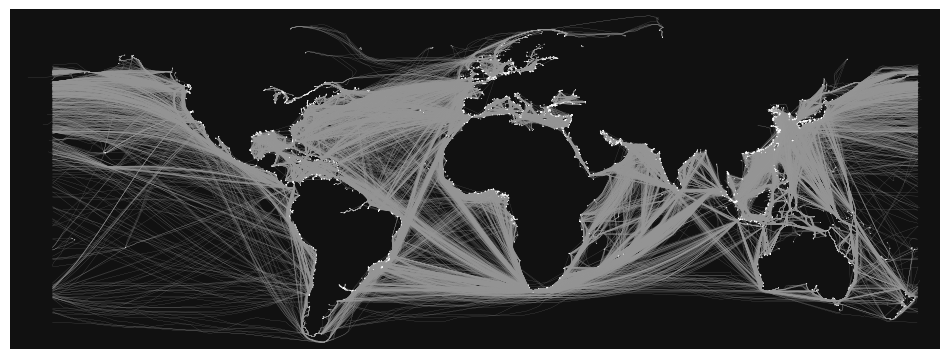

In [516]:
fig, ax = ox.plot_graph(G, figsize=(12, 14), node_size=0.5, edge_linewidth=0.1)

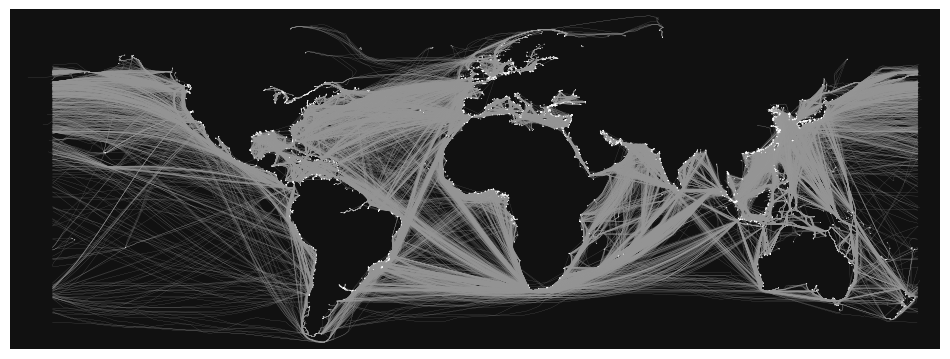

In [289]:
fig, ax = ox.plot_graph(G, figsize=(12, 14), node_size=0.5, edge_linewidth=0.1)